Install and import our libraries

In [5]:
import sys
!{sys.executable} -m pip install pandas numpy scikit-learn

import pandas as pd
import numpy as np
import re

from sklearn import svm
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error

import pickle
from datetime import datetime
import time

from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier


from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
from IPython.display import clear_output

true=True
false=False

DTYPE_DICT = {"INCIDENT_TYPE_DESC":"uint16","UNITS_ONSCENE":"uint8","TOTAL_INCIDENT_DURATION":"uint16","ACTION_TAKEN1_DESC":"int16","ACTION_TAKEN2_DESC":"int16","ACTION_TAKEN3_DESC":"int16","PROPERTY_USE_DESC":"int16","BOROUGH_DESC":"uint8","SEASON":"uint8","TIME_OF_DAY":"uint8","WEEKDAY":"uint8"}
DROP_COLUMNS = ["IM_INCIDENT_KEY","FIRE_BOX", "ARRIVAL_DATE_TIME", "LAST_UNIT_CLEARED_DATE_TIME", "HIGHEST_LEVEL_DESC", "STREET_HIGHWAY", "ZIP_CODE", "FLOOR", "CO_DETECTOR_PRESENT_DESC", "FIRE_ORIGIN_BELOW_GRADE_FLAG", "STORY_FIRE_ORIGIN_COUNT", "FIRE_SPREAD_DESC", "DETECTOR_PRESENCE_DESC", "AES_PRESENCE_DESC", "STANDPIPE_SYS_PRESENT_FLAG"]

LOAD PREPROCESSED DATA IF ALREADY PREPROCESSED

In [6]:
data = pd.read_csv("preprocessed.csv.gzip",compression="gzip",dtype=DTYPE_DICT)
data.head(10)

,INCIDENT_TYPE_DESC,UNITS_ONSCENE,TOTAL_INCIDENT_DURATION,ACTION_TAKEN1_DESC,ACTION_TAKEN2_DESC,ACTION_TAKEN3_DESC,PROPERTY_USE_DESC,BOROUGH_DESC,SEASON,TIME_OF_DAY,WEEKDAY,HOUR,MONTH,YEAR
0,300,1,1186,0,0,0,999,2,0,0,1,0,1,2013
1,735,3,1769,86,0,0,999,1,0,0,1,0,1,2013
2,300,1,841,0,0,0,999,5,0,0,1,0,1,2013
3,412,4,2259,44,64,82,429,5,0,0,1,0,1,2013
4,735,6,1387,86,0,0,999,5,0,0,1,0,1,2013
5,735,3,935,86,0,0,999,4,0,0,1,0,1,2013
6,353,1,1598,64,0,0,429,1,0,0,1,0,1,2013
7,651,4,438,86,0,0,960,5,0,0,1,0,1,2013
8,331,1,1132,70,0,0,429,2,0,0,1,0,1,2013
9,710,6,319,0,0,0,999,4,0,0,1,0,1,2013


SET SPLIT SIZES

In [7]:
print("Splitting datasets...")
data.drop(["HOUR"], axis=1, inplace=True)
data.drop(["MONTH"], axis=1, inplace=True)
data.drop(["YEAR"], axis=1, inplace=True)
data_train, data_test = train_test_split(data, train_size=0.7, test_size=0.3)
data_train = data_train.astype(DTYPE_DICT)
data_test = data_test.astype(DTYPE_DICT)
del(data)

Splitting datasets...


UOS

In [8]:
# SET UP PREDICTION FUNCTION
uos_mdl_dict = {}

uni = data_train["INCIDENT_TYPE_DESC"].unique()
i = 0

def predict(df):
    res = []
    for i,row in df.iterrows():
        itype = row["INCIDENT_TYPE_DESC"]
        pud = row["PROPERTY_USE_DESC"]
        if not itype in uos_mdl_dict.keys() or not pud in uos_mdl_dict[itype].keys():
            # This combination was not in the training data! return 0
            res.append(0)
            continue
        df = pd.DataFrame(data=[list(row)], columns=["INCIDENT_TYPE_DESC","UNITS_ONSCENE","TOTAL_INCIDENT_DURATION","ACTION_TAKEN1_DESC","ACTION_TAKEN2_DESC","ACTION_TAKEN3_DESC","PROPERTY_USE_DESC","BOROUGH_DESC","SEASON","TIME_OF_DAY","WEEKDAY"])
        res.append(uos_mdl_dict[itype][pud].predict(df[["BOROUGH_DESC","SEASON","TIME_OF_DAY","WEEKDAY"]])[0])
    return res

# ----------------------------------------------------------------------------

# TRAINING RFC FOR UOS
print("Initializing training of RFR with dictionary + 3 trees for UOS")

print("Training...")

uos_mdl_dict = {}

uni = data_train["INCIDENT_TYPE_DESC"].unique()
i = 0

for itype in uni:
    uos_mdl_dict[itype] = {}
    dt_itype = data_train[data_train['INCIDENT_TYPE_DESC'] == itype]
    for pud in dt_itype["PROPERTY_USE_DESC"].unique():
        dt_pud = dt_itype[dt_itype["PROPERTY_USE_DESC"] == pud]
        uos_mdl_dict[itype][pud] = RandomForestRegressor(n_estimators=3)
        uos_mdl_dict[itype][pud].fit(dt_pud[["BOROUGH_DESC","SEASON","TIME_OF_DAY","WEEKDAY"]],dt_pud.UNITS_ONSCENE)
    i += 1

print("Saving UOS RFR")
with open("uos_dict_rfc.pickle","wb") as file:
    pickle.dump(uos_mdl_dict,file)

print("Predicting")
res = predict(data_test)
mae1 = mean_absolute_error(data_test.UNITS_ONSCENE,res)
print("RFR UOS MAE:", mae1)


# ----------------------------------------------------------------------------
#TRAINING BAYESIAN RIDGE FOR UOS
print("Initializing training of Bay. Ridge for UOS")

print("Training...")


uos_mdl_dict = {}

uni = data_train["INCIDENT_TYPE_DESC"].unique()
i = 0

for itype in uni:
    uos_mdl_dict[itype] = {}
    dt_itype = data_train[data_train['INCIDENT_TYPE_DESC'] == itype]
    for pud in dt_itype["PROPERTY_USE_DESC"].unique():
        dt_pud = dt_itype[dt_itype["PROPERTY_USE_DESC"] == pud]
        uos_mdl_dict[itype][pud] = linear_model.BayesianRidge()
        uos_mdl_dict[itype][pud].fit(dt_pud[["BOROUGH_DESC","SEASON","TIME_OF_DAY","WEEKDAY"]],dt_pud.UNITS_ONSCENE)
    i += 1

print("Saving UOS Bay")
with open("uos_dict_bayesian.pickle","wb") as file:
    pickle.dump(uos_mdl_dict,file)

print("Predicting")
res = predict(data_test)
mae2 = mean_absolute_error(data_test.UNITS_ONSCENE,res)
print("Bay UOS MAE:", mae2)


Initializing training of RFR with dictionary + 3 trees for UOS
Training...
Saving UOS RFR
Predicting
RFR UOS MAE: 0.6685425246993395
Initializing training of Bay. Ridge for UOS
Training...
Saving UOS Bay
Predicting
Bay UOS MAE: 0.637946350601583


UOS RESULTS

0.6685425246993395
0.637946350601583


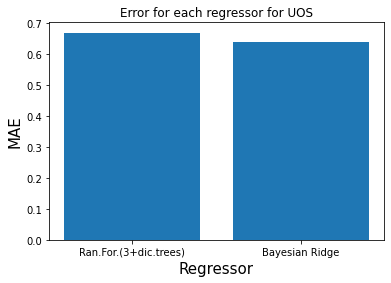

In [9]:
#RESULTS
# Plot the result of each regressor
print(mae1)
print(mae2)

classifiers = ['Ran.For.(3+dic.trees)', 'Bayesian Ridge']
error = [mae1, mae2]
plt.bar(classifiers, error)
plt.title('Error for each regressor for UOS')
plt.xlabel('Regressor', fontsize=15)
plt.ylabel('MAE', fontsize=15)
plt.show()


TOTAL INCIDENT DURATION

In [10]:
# SET UP PREDICTION FUNCTION
tid_mdl_dict = {}

uni = data_train["INCIDENT_TYPE_DESC"].unique()
i = 0

def predict(df):
    res = []
    for i,row in df.iterrows():
        itype = row["INCIDENT_TYPE_DESC"]
        pud = row["PROPERTY_USE_DESC"]
        if not itype in tid_mdl_dict.keys() or not pud in tid_mdl_dict[itype].keys():
            # This combination was not in the training data! return 0
            res.append(0)
            continue
        df = pd.DataFrame(data=[list(row)], columns=["INCIDENT_TYPE_DESC","UNITS_ONSCENE","TOTAL_INCIDENT_DURATION","ACTION_TAKEN1_DESC","ACTION_TAKEN2_DESC","ACTION_TAKEN3_DESC","PROPERTY_USE_DESC","BOROUGH_DESC","SEASON","TIME_OF_DAY","WEEKDAY"])
        res.append(tid_mdl_dict[itype][pud].predict(df[["BOROUGH_DESC","SEASON","TIME_OF_DAY","WEEKDAY"]])[0])
    return res

# ----------------------------------------------------------------------------

#TRAINING RFC FOR INCIDENT DURATION
print("Initializing training of RFR with 3 + dict trees for Incident Duration")

print("Training...")

tid_mdl_dict = {}

uni = data_train["INCIDENT_TYPE_DESC"].unique()
i = 0

for itype in uni:
    tid_mdl_dict[itype] = {}
    dt_itype = data_train[data_train['INCIDENT_TYPE_DESC'] == itype]
    for pud in dt_itype["PROPERTY_USE_DESC"].unique():
        dt_pud = dt_itype[dt_itype["PROPERTY_USE_DESC"] == pud]
        tid_mdl_dict[itype][pud] = RandomForestRegressor(n_estimators=3)
        tid_mdl_dict[itype][pud].fit(dt_pud[["BOROUGH_DESC","SEASON","TIME_OF_DAY","WEEKDAY"]],dt_pud.TOTAL_INCIDENT_DURATION)
    i += 1

print("Saving tid RFR")
with open("tid_dict_rfc.pickle","wb") as file:
    pickle.dump(tid_mdl_dict,file)

print("Predicting")
res = predict(data_test)
mae1 = mean_absolute_error(data_test.TOTAL_INCIDENT_DURATION,res)
print("RFR tid MAE:", mae1)


# ----------------------------------------------------------------------------
#TRAINING BAYESIAN RIDGE FOR INCIDENT DURATION
print("Initializing training of Bay. Ridge for Incident Duration")

print("Training...")


tid_mdl_dict = {}

uni = data_train["INCIDENT_TYPE_DESC"].unique()
i = 0

for itype in uni:
    tid_mdl_dict[itype] = {}
    dt_itype = data_train[data_train['INCIDENT_TYPE_DESC'] == itype]
    for pud in dt_itype["PROPERTY_USE_DESC"].unique():
        dt_pud = dt_itype[dt_itype["PROPERTY_USE_DESC"] == pud]
        tid_mdl_dict[itype][pud] = linear_model.BayesianRidge()
        tid_mdl_dict[itype][pud].fit(dt_pud[["BOROUGH_DESC","SEASON","TIME_OF_DAY","WEEKDAY"]],dt_pud.TOTAL_INCIDENT_DURATION)
    i += 1

print("Saving tid bay")
with open("tid_dict_bay.pickle","wb") as file:
    pickle.dump(tid_mdl_dict,file)

print("Predicting")
res = predict(data_test)
mae2 = mean_absolute_error(data_test.TOTAL_INCIDENT_DURATION,res)
print("Bay tid MAE:", mae2)


Initializing training of RFR with 3 + dict trees for Incident Duration
Training...
Saving tid RFR
Predicting
RFR tid MAE: 684.2190120489242
Initializing training of Bay. Ridge for Incident Duration
Training...
Saving tid bay
Predicting
Bay tid MAE: 665.5250608023754


TID RESULTS

684.2190120489242
665.5250608023754


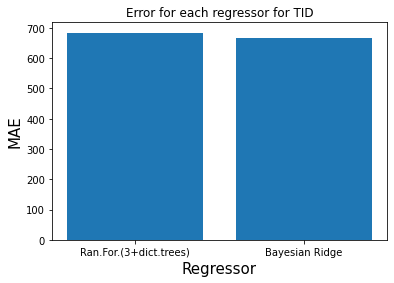

In [11]:
# Plot the result of each regressor
print(mae1)
print(mae2)
classifiers = ['Ran.For.(3+dict.trees)', 'Bayesian Ridge']
error = [mae1, mae2]
plt.bar(classifiers, error)
plt.title('Error for each regressor for TID')
plt.xlabel('Regressor', fontsize=15)
plt.ylabel('MAE', fontsize=15)
plt.show()


ACTION TAKEN 1

In [12]:
# SET UP PREDICTION FUNCTION
at1_mdl_dict = {}

uni = data_train["INCIDENT_TYPE_DESC"].unique()
i = 0

def predict(df):
    res = []
    for i,row in df.iterrows():
        itype = row["INCIDENT_TYPE_DESC"]
        pud = row["PROPERTY_USE_DESC"]
        if not itype in at1_mdl_dict.keys() or not pud in at1_mdl_dict[itype].keys():
            # This combination was not in the training data! return 0
            res.append(0)
            continue
        df = pd.DataFrame(data=[list(row)], columns=["INCIDENT_TYPE_DESC","UNITS_ONSCENE","TOTAL_INCIDENT_DURATION","ACTION_TAKEN1_DESC","ACTION_TAKEN2_DESC","ACTION_TAKEN3_DESC","PROPERTY_USE_DESC","BOROUGH_DESC","SEASON","TIME_OF_DAY","WEEKDAY"])
        res.append(at1_mdl_dict[itype][pud].predict(df[["BOROUGH_DESC","SEASON","TIME_OF_DAY","WEEKDAY"]])[0])
    return res

# ----------------------------------------------------------------------------

#TRAINING RFC with dict + 3 for Action 1
print("Initializing training of RFC with 3 + dict trees for AT1")

print("Training...")

at1_mdl_dict = {}

uni = data_train["INCIDENT_TYPE_DESC"].unique()
i = 0

for itype in uni:
    at1_mdl_dict[itype] = {}
    dt_itype = data_train[data_train['INCIDENT_TYPE_DESC'] == itype]
    for pud in dt_itype["PROPERTY_USE_DESC"].unique():
        dt_pud = dt_itype[dt_itype["PROPERTY_USE_DESC"] == pud]
        at1_mdl_dict[itype][pud] = RandomForestClassifier(n_estimators=3)
        at1_mdl_dict[itype][pud].fit(dt_pud[["BOROUGH_DESC","SEASON","TIME_OF_DAY","WEEKDAY"]],dt_pud.ACTION_TAKEN1_DESC)
    i += 1

print("Saving at1 RFC")
with open("at1_dict_rfc.pickle","wb") as file:
    pickle.dump(at1_mdl_dict,file)

print("Predicting")
res = predict(data_test)
mae1 = accuracy_score(data_test.ACTION_TAKEN1_DESC,res)
print("RFC at1 accuracy:", mae1)


# ----------------------------------------------------------------------------
#TRAINING ridge FOR AT 1
print("Initializing training of ridge for AT1")

print("Training...")

at1_mdl_dict = {}

uni = data_train["INCIDENT_TYPE_DESC"].unique()
i = 0

for itype in uni:
    at1_mdl_dict[itype] = {}
    dt_itype = data_train[data_train['INCIDENT_TYPE_DESC'] == itype]
    for pud in dt_itype["PROPERTY_USE_DESC"].unique():
        dt_pud = dt_itype[dt_itype["PROPERTY_USE_DESC"] == pud]
        at1_mdl_dict[itype][pud] = RidgeClassifier()
        at1_mdl_dict[itype][pud].fit(dt_pud[["BOROUGH_DESC","SEASON","TIME_OF_DAY","WEEKDAY"]],dt_pud.ACTION_TAKEN1_DESC)
    i += 1

print("Saving at1 ridge")
with open("at1_dict_ridge.pickle","wb") as file:
    pickle.dump(at1_mdl_dict,file)

print("Predicting")
res = predict(data_test)
mae2 = accuracy_score(data_test.ACTION_TAKEN1_DESC,res)
print("ridge at1 accuracy:", mae2)


Initializing training of RFC with 3 + dict trees for AT1
Training...
Saving at1 RFC
Predicting
RFC at1 accuracy: 0.9198730588942149
Initializing training of ridge for AT1
Training...
Saving at1 ridge
Predicting
ridge at1 accuracy: 0.9293129140606596


RESULTS FOR ACTION TAKEN

0.9198730588942149
0.9293129140606596


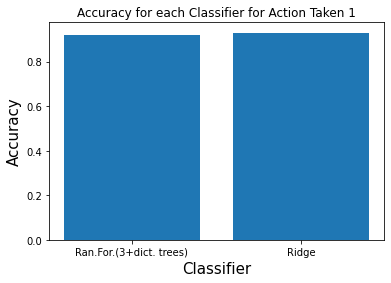

In [13]:
# Plot the result of each classifier
print(mae1)
print(mae2)
classifiers = ['Ran.For.(3+dict. trees)', 'Ridge']
error = [mae1, mae2]
plt.bar(classifiers, error)
plt.title('Accuracy for each Classifier for Action Taken 1')
plt.xlabel('Classifier', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.show()

ACTION TAKEN 2

In [14]:
# SET UP PREDICTION FUNCTION
at2_mdl_dict = {}

uni = data_train["INCIDENT_TYPE_DESC"].unique()
i = 0

def predict(df):
    res = []
    for i,row in df.iterrows():
        itype = row["INCIDENT_TYPE_DESC"]
        pud = row["PROPERTY_USE_DESC"]
        if not itype in at2_mdl_dict.keys() or not pud in at2_mdl_dict[itype].keys():
            # This combination was not in the training data! return 0
            res.append(0)
            continue
        df = pd.DataFrame(data=[list(row)], columns=["INCIDENT_TYPE_DESC","UNITS_ONSCENE","TOTAL_INCIDENT_DURATION","ACTION_TAKEN1_DESC","ACTION_TAKEN2_DESC","ACTION_TAKEN3_DESC","PROPERTY_USE_DESC","BOROUGH_DESC","SEASON","TIME_OF_DAY","WEEKDAY"])
        res.append(at2_mdl_dict[itype][pud].predict(df[["BOROUGH_DESC","SEASON","TIME_OF_DAY","WEEKDAY"]])[0])
    return res

# ----------------------------------------------------------------------------

#TRAINING RFC FOR at2
print("Initializing training of RFC with 3 + dict trees for at2")

print("Training...")

at2_mdl_dict = {}

uni = data_train["INCIDENT_TYPE_DESC"].unique()
i = 0

for itype in uni:
    at2_mdl_dict[itype] = {}
    dt_itype = data_train[data_train['INCIDENT_TYPE_DESC'] == itype]
    for pud in dt_itype["PROPERTY_USE_DESC"].unique():
        dt_pud = dt_itype[dt_itype["PROPERTY_USE_DESC"] == pud]
        at2_mdl_dict[itype][pud] = RandomForestClassifier(n_estimators=3)
        at2_mdl_dict[itype][pud].fit(dt_pud[["BOROUGH_DESC","SEASON","TIME_OF_DAY","WEEKDAY"]],dt_pud.ACTION_TAKEN2_DESC)
    i += 1

print("Saving at2 RFC")
with open("at2_dict_rfc.pickle","wb") as file:
    pickle.dump(at2_mdl_dict,file)

print("Predicting")
res = predict(data_test)
mae1 = accuracy_score(data_test.ACTION_TAKEN2_DESC,res)
print("RFC at2 accuracy:", mae1)


# ----------------------------------------------------------------------------
#TRAINING ridge FOR INCIDENT DURATION
print("Initializing training of ADA for Incident Duration")

print("Training...")

at2_mdl_dict = {}

uni = data_train["INCIDENT_TYPE_DESC"].unique()
i = 0

for itype in uni:
    at2_mdl_dict[itype] = {}
    dt_itype = data_train[data_train['INCIDENT_TYPE_DESC'] == itype]
    for pud in dt_itype["PROPERTY_USE_DESC"].unique():
        dt_pud = dt_itype[dt_itype["PROPERTY_USE_DESC"] == pud]
        at2_mdl_dict[itype][pud] = RidgeClassifier()
        at2_mdl_dict[itype][pud].fit(dt_pud[["BOROUGH_DESC","SEASON","TIME_OF_DAY","WEEKDAY"]],dt_pud.ACTION_TAKEN2_DESC)
    i += 1

print("Saving at2 ridge")
with open("at2_dict_ridge.pickle","wb") as file:
    pickle.dump(at2_mdl_dict,file)

print("Predicting")
res = predict(data_test)
mae2 = accuracy_score(data_test.ACTION_TAKEN2_DESC,res)
print("ridge at2 accuracy:", mae2)



Initializing training of RFC with 3 + dict trees for at2
Training...
Saving at2 RFC
Predicting
RFC at2 accuracy: 0.9320404538753299
Initializing training of ADA for Incident Duration
Training...
Saving at2 ridge
Predicting
ridge at2 accuracy: 0.9409760913467774


0.9320404538753299
0.9409760913467774


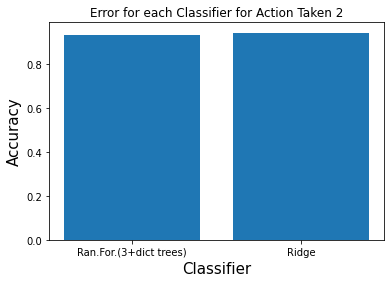

In [15]:
# Plot the result of each classifier
print(mae1)
print(mae2)
classifiers = ['Ran.For.(3+dict trees)', 'Ridge']
error = [mae1, mae2]
plt.bar(classifiers, error)
plt.title('Error for each Classifier for Action Taken 2')
plt.xlabel('Classifier', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.show()

ACTION TAKEN 3

In [16]:
# SET UP PREDICTION FUNCTION
at3_mdl_dict = {}

uni = data_train["INCIDENT_TYPE_DESC"].unique()
i = 0

def predict(df):
    res = []
    for i,row in df.iterrows():
        itype = row["INCIDENT_TYPE_DESC"]
        pud = row["PROPERTY_USE_DESC"]
        if not itype in at3_mdl_dict.keys() or not pud in at3_mdl_dict[itype].keys():
            # This combination was not in the training data! return 0
            res.append(0)
            continue
        df = pd.DataFrame(data=[list(row)], columns=["INCIDENT_TYPE_DESC","UNITS_ONSCENE","TOTAL_INCIDENT_DURATION","ACTION_TAKEN1_DESC","ACTION_TAKEN2_DESC","ACTION_TAKEN3_DESC","PROPERTY_USE_DESC","BOROUGH_DESC","SEASON","TIME_OF_DAY","WEEKDAY"])
        res.append(at3_mdl_dict[itype][pud].predict(df[["BOROUGH_DESC","SEASON","TIME_OF_DAY","WEEKDAY"]])[0])
    return res

# ----------------------------------------------------------------------------

#TRAINING RFC FOR at3
print("Initializing training of RFC with 3 + dict for at3")

print("Training...")

at3_mdl_dict = {}

uni = data_train["INCIDENT_TYPE_DESC"].unique()
i = 0

for itype in uni:
    at3_mdl_dict[itype] = {}
    dt_itype = data_train[data_train['INCIDENT_TYPE_DESC'] == itype]
    for pud in dt_itype["PROPERTY_USE_DESC"].unique():
        dt_pud = dt_itype[dt_itype["PROPERTY_USE_DESC"] == pud]
        at3_mdl_dict[itype][pud] = RandomForestClassifier(n_estimators=3)
        at3_mdl_dict[itype][pud].fit(dt_pud[["BOROUGH_DESC","SEASON","TIME_OF_DAY","WEEKDAY"]],dt_pud.ACTION_TAKEN3_DESC)
    i += 1

print("Saving at3 RFC")
with open("at3_dict_rfc.pickle","wb") as file:
    pickle.dump(at3_mdl_dict,file)

print("Predicting")
res = predict(data_test)
mae1 = accuracy_score(data_test.ACTION_TAKEN3_DESC,res)
print("RFC at3 accuracy:", mae1)


# ----------------------------------------------------------------------------
#TRAINING ridge FOR AT3
print("Initializing training of ridge for at3")

print("Training...")

at3_mdl_dict = {}

uni = data_train["INCIDENT_TYPE_DESC"].unique()
i = 0

for itype in uni:
    at3_mdl_dict[itype] = {}
    dt_itype = data_train[data_train['INCIDENT_TYPE_DESC'] == itype]
    for pud in dt_itype["PROPERTY_USE_DESC"].unique():
        dt_pud = dt_itype[dt_itype["PROPERTY_USE_DESC"] == pud]
        at3_mdl_dict[itype][pud] = RidgeClassifier()
        at3_mdl_dict[itype][pud].fit(dt_pud[["BOROUGH_DESC","SEASON","TIME_OF_DAY","WEEKDAY"]],dt_pud.ACTION_TAKEN3_DESC)
    i += 1

print("Saving at3 ridge")
with open("at3_dict_ridge.pickle","wb") as file:
    pickle.dump(at3_mdl_dict,file)

print("Predicting")
res = predict(data_test)
mae2 = accuracy_score(data_test.ACTION_TAKEN3_DESC,res)
print("ridge at3 accuracy:", mae2)


Initializing training of RFC with 3 + dict for at3
Training...
Saving at3 RFC
Predicting
RFC at3 accuracy: 0.9617045998946568
Initializing training of ridge for at3
Training...
Saving at3 ridge
Predicting
ridge at3 accuracy: 0.9664595977375051


0.9617045998946568
0.9664595977375051


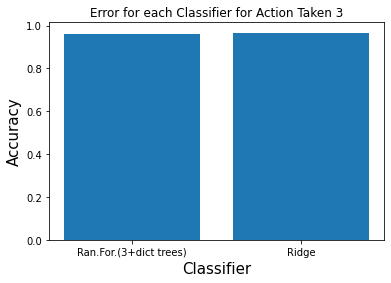

In [17]:
# Plot the result of each classifier
print(mae1)
print(mae2)
classifiers = ['Ran.For.(3+dict trees)', 'Ridge']
error = [mae1, mae2]
plt.bar(classifiers, error)
plt.title('Error for each Classifier for Action Taken 3')
plt.xlabel('Classifier', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.show()